# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your http://notebook.acuna.io workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [111]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark import sql

import matplotlib.pyplot as plt
import pandas as pd

# Part 1: Admission analysis

In this assignment, you will have to do an analysis on graduate admission dataset. 

# Admission data analysis
```console
1. Title: Graduate Admission Data

2. Sources:
    Mohan S Acharya, Asfia Armaan, Aneeta S Antony : A Comparison of Regression Models for Prediction of Graduate Admissions, IEEE International Conference on Computational Intelligence in Data Science 2019
    
3. Number of Instances: 400

4. Numer of Attributes: 8 + numeric chance of admit 

5. Attribute information:
    
    1. Region: A,B,C,D,E
    2. GRE_Score: out of 340
    3. TOEFL_Scores: out of 120 
    4. University_Rating: out of 5 
    5. SOP (Statement of Purpose): out of 5
    6. LOR (Letter of Recommendation): out of 5 
    7. CGPA (Undergraduate GPA): out of 10 
    8. Research (Research Experience): either 0 or 1 
    9. Chance_of_Admit: ranging from 0 to 1 
```

In [112]:
# Load the data
admission_df = spark.createDataFrame(pd.read_csv('Admission_Predict.csv', sep=','))

# 1. Explore the data

With big data, datasets can be too big to bring them into the Spark client. However, we can use the `limit` method of a dataframe to limit the number of rows to bring as a Pandas dataframe.

Create a dataframe `admission_sample_df` with the first 30 rows of `admission_df`

In [113]:
# create 
admission_sample_df = admission_df.limit(30)

In [114]:
# 1 pts - right number of rows
np.testing.assert_equal(admission_sample_df.count(), 30)

**(7 pts)** Below, transform `admission_sample_df` into a Pandas dataframe and do a scatter plot of `GRE_Score` vs `TOEFL_Score`. In addition, grouping each point with different color based on `Chance_of_Admit`. If the chance over 0.6, colored the points blue; otherwise, colored the points red. Last, describe what you find? (Remember to add **axis titles**)

In [115]:
# 5 pts: Scatter plot of GRE_Score vs TOEFL_Score

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
df = admission_sample_df.toPandas()

In [116]:
df.Chance_of_Admit.describe()

count    30.000000
mean      0.698000
std       0.158949
min       0.440000
25%       0.612500
50%       0.670000
75%       0.795000
max       0.970000
Name: Chance_of_Admit, dtype: float64

In [117]:
df.GRE_Score.describe()

count     30.000000
mean     318.866667
std       11.515307
min      295.000000
25%      311.250000
50%      320.000000
75%      326.500000
max      340.000000
Name: GRE_Score, dtype: float64

In [118]:
df['color'] = np.where(df['Chance_of_Admit'] >= 0.6, 1, 0)

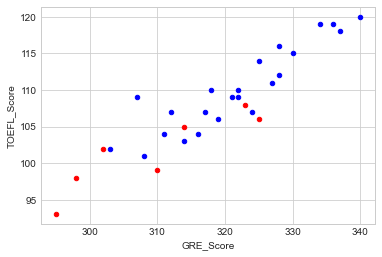

In [119]:
admitg6 = df[df['color'] == 1]
admitl6 = df[df['color'] == 0]
ax0 = admitg6.plot(x='GRE_Score', y='TOEFL_Score', kind='scatter', color='blue')
ax1 = admitl6.plot(x='GRE_Score', y='TOEFL_Score', kind='scatter', color='red', ax=ax0)

In [120]:
# 2 pts: What you find based on the scatter plot?
# Some of the lowest TOEFL and GRE scores have the lowest chance of admission, but there are outliers 
# Applicants with GRE scores above 320 have the highest chance of admission, but with lower TOEFL scores chance of admission decreases 
# Applicants with TOEFL scores above 110 have the highest chance of admission
# Half of applicants in the dataset have above a 67% chance of admission
#raise NotImplementedError()

## Perform correlations between SOP, LOR, and CGPA

Create a `admission_corr_df` dataframe that contains the correlations between `SOP` and `LOR` as a column `corr_SOP_LOR`, between `LOR` and `CGPA` as `corr_LOR_CGPA`, and `SOP` and `CGPA` as `corr_SOP_CGPA`. (Using admission_df)

In [121]:
admission_corr_df = admission_df.select(fn.corr('SOP', 'LOR').alias('corr_SOP_LOR'), fn.corr("LOR", "CGPA").alias('corr_LOR_CGPA'), fn.corr("SOP", "CGPA").alias('corr_SOP_CGPA'))

In [122]:
# 3 pts
np.testing.assert_equal(set(admission_corr_df.columns), 
                        {'corr_SOP_LOR', 'corr_LOR_CGPA', 'corr_SOP_CGPA'})
np.testing.assert_almost_equal(list(admission_corr_df.first().asDict().values()),
                               [0.7295925366175836, 0.6702112958281646, 0.718143958057528], decimal=3)

## Compute mean and standard deviation Change_of_Admit for regions

Create `region_chance_df` with the column `region`, `avg_chance`, and `sd_chance`, where `avg_chance` is the average chance of admit in different regions and `sd_chance` is the standard deviation of chance of admit. Sort the resulting dataframe from highest to lowest average chance of admit.

In [123]:
region_chance_df = admission_df.groupby('region').agg(fn.mean('Chance_of_Admit').alias('avg_chance'), fn.stddev('Chance_of_Admit').alias('sd_chance')) 


#raise NotImplementedError()

In [124]:
# 5 pts
np.testing.assert_array_almost_equal(
    (region_chance_df.orderBy('region').select('avg_chance').\
     rdd.map(lambda x: list(x.asDict().values())).collect()),
[[0.7283529411764705],
 [0.712],
 [0.7020000000000001],
 [0.734],
 [0.7501538461538463]], decimal=3)

np.testing.assert_array_almost_equal(
    (region_chance_df.orderBy('region').select('sd_chance').\
     rdd.map(lambda x: list(x.asDict().values())).collect()),
[[0.1474533587179311],
 [0.13247461571759256],
 [0.14784014630931444],
 [0.14602022038712573],
 [0.1364103678667368]], decimal=3)

# Feature Engineering

## Dummy variables for region
Create a dataframe `dummy_df` with columns `region` as dummy variables, and columns `GRE_Score`, `TOEFL_Score`, `CGPA`, `University_Rating`, and `Chance_of_Admit`. Use region B as the baselines and name the dummy variables `region_A` for region `A` and so on. The dataframe `dummy_df` should not contain the column `region` but only its dummy variable representations. **All column types should be float or integer.**

In [125]:
#admission_df.groupby('region').agg(fn.mean('GRE_Score')).show()

df = admission_df.toPandas()
df['Region_A'] = np.where(df['Region'] == 'A', 1, 0)
df['Region_B'] = np.where(df['Region'] == 'B', 1, 0)
df['Region_C'] = np.where(df['Region'] == 'C', 1, 0)
df['Region_D'] = np.where(df['Region'] == 'D', 1, 0)
df['Region_E'] = np.where(df['Region'] == 'E', 1, 0)

df = df[['GRE_Score','TOEFL_Score', 'CGPA', 'University_Rating','Chance_of_Admit', 'Region_A', 'Region_C', 'Region_D', 'Region_E']]
df.info()
dummy_df = spark.createDataFrame(df)
dummy_df.printSchema()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE_Score          400 non-null    int64  
 1   TOEFL_Score        400 non-null    int64  
 2   CGPA               400 non-null    float64
 3   University_Rating  400 non-null    int64  
 4   Chance_of_Admit    400 non-null    float64
 5   Region_A           400 non-null    int64  
 6   Region_C           400 non-null    int64  
 7   Region_D           400 non-null    int64  
 8   Region_E           400 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 28.2 KB
root
 |-- GRE_Score: long (nullable = true)
 |-- TOEFL_Score: long (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- University_Rating: long (nullable = true)
 |-- Chance_of_Admit: double (nullable = true)
 |-- Region_A: long (nullable = true)
 |-- Region_C: long (nullable = true)
 |-- Region_D: long (nulla

In [126]:
# 5 pts
np.testing.assert_equal(len(dummy_df.columns), 9)
np.testing.assert_equal(dummy_df.select(fn.sum('Region_A')).first()['sum(Region_A)'], 85)
np.testing.assert_equal(dummy_df.select(fn.sum('Region_D')).first()['sum(Region_D)'], 85)

# Model comparison

In the next set of questions, you will use the splits below to fit, validate, and estimate the generalization error of your models. The `randomSplit` is called with a seed so that it does not change from what the professor used.

In [127]:
training_df, validation_df, testing_df = dummy_df.randomSplit([0.6, 0.3, 0.1], seed=0)
print("# points in training: ", training_df.count())
print("# points in validation: ", validation_df.count())
print("# points in testing: ", testing_df.count())

# points in training:  227
# points in validation:  126
# points in testing:  47


## Propose three regression models

In the next section, you will choose the best model to explain the data in `admission_df`. Select the right split of the data for the right step of the process (i.e., training, validation, and testing)

### Model 1: Fit model with only `GRE_Score`

Create a pipeline that takes **GRE_Score** as a feature to predict **Chance_of_Admit** and fits a linear regression model. You should start your pipeline by taking the appropriate column or columns from `dummy_df`. Assign the fit pipeline transformer to `pipe_model1`. Your pipeline must have one vector assembler followed by a linear regression.

In [128]:
!pip install git+https://github.com/daniel-acuna/pyspark_pipes.git

  Cloning https://github.com/daniel-acuna/pyspark_pipes.git to /private/var/folders/p4/l5_451cn5p9gmxv7541xf3n80000gn/T/pip-req-build-_duwwv50
  Running command git clone -q https://github.com/daniel-acuna/pyspark_pipes.git /private/var/folders/p4/l5_451cn5p9gmxv7541xf3n80000gn/T/pip-req-build-_duwwv50
You should consider upgrading via the '/Users/courtneyhrdy/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [129]:
from pyspark.ml import regression
from pyspark.ml import feature

pipe_model1 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['GRE_Score'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='Chance_of_Admit')  
]).fit(training_df)



In [130]:
# (5 pts)
np.testing.assert_equal(type(pipe_model1.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model1.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model1.stages[1].coefficients.shape, (1,))

### Model 2: Fit model with `GRE_Score` and `TOEFL_Score`

Follow the same idea as above and create a pipeline transformer `pipe_model2`

In [131]:
pipe_model2 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['GRE_Score', 'TOEFL_Score'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='Chance_of_Admit')  
]).fit(training_df)

In [132]:
training_df.show()

+---------+-----------+----+-----------------+---------------+--------+--------+--------+--------+
|GRE_Score|TOEFL_Score|CGPA|University_Rating|Chance_of_Admit|Region_A|Region_C|Region_D|Region_E|
+---------+-----------+----+-----------------+---------------+--------+--------+--------+--------+
|      298|         98| 7.5|                2|           0.44|       1|       0|       0|       0|
|      299|        106| 8.4|                2|           0.64|       1|       0|       0|       0|
|      300|         97| 8.1|                2|           0.65|       0|       1|       0|       0|
|      302|        102| 8.0|                1|            0.5|       0|       0|       1|       0|
|      303|        102| 8.5|                3|           0.62|       0|       0|       0|       0|
|      304|        105| 7.5|                1|           0.52|       0|       0|       0|       0|
|      307|        109| 8.0|                3|           0.62|       0|       0|       0|       0|
|      308

In [133]:
# (5 pts)
np.testing.assert_equal(type(pipe_model2.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model2.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model2.stages[1].coefficients.shape, (2,))

### Model 3: Fit model with region, GRE_Score, TOEFL_Score, CGPA, and Univeristy_Rating

Follow the same idea as above and create a pipeline transformer `pipe_model3`. Remember that some features have been feature engineered. In particular, use the transformed columns in the order: region, GRE_Score, TOEFL_Score, CGPA, and Univeristy_Rating. Choose the columns from `dummy_df` appropriately.

In [134]:
pipe_model3 = Pipeline(stages=[feature.VectorAssembler(inputCols = ['Region_A', 'Region_C', 'Region_D', 'Region_E','GRE_Score', 'TOEFL_Score', 'CGPA', 'University_Rating'], 
                                              outputCol='features'),
                              regression.LinearRegression(featuresCol='features', labelCol='Chance_of_Admit')
                              ]).fit(training_df)

In [135]:
pipe_model3.stages[1]

LinearRegressionModel: uid=LinearRegression_326fe93953db, numFeatures=8

In [136]:
# (5 pts)
np.testing.assert_equal(type(pipe_model3.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model3.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model3.stages[1].coefficients.shape, (8,))

# Compare models

### Estimate RMSE on validation data for the three models

Create three dataframes `rmse1_df`, `rmse2_df`, and `rmse3_df` for models 1, 2, and 3, respectively, with only column `rmse`

In [137]:
# create rmse1_df, rmse2_df, and rmse3_df dataframes below
from pyspark.sql import functions as fn
from pyspark.sql.functions import *
rmse = fn.sqrt(fn.mean((fn.col('Chance_of_Admit') - fn.col('prediction'))**2)).alias('rmse')


rmse1_df = pipe_model1.transform(training_df).select(rmse)
rmse2_df = pipe_model2.transform(training_df).select(rmse)
rmse3_df = pipe_model3.transform(training_df).select(rmse)

In [138]:
# display the answers here
rmse1_df.show()
rmse2_df.show()
rmse3_df.show()

+-------------------+
|               rmse|
+-------------------+
|0.08161124716698956|
+-------------------+

+-------------------+
|               rmse|
+-------------------+
|0.07451896176272202|
+-------------------+

+-------------------+
|               rmse|
+-------------------+
|0.06296444607202685|
+-------------------+



In [139]:
# (5 pts)
np.testing.assert_equal(rmse1_df.count(), 1)
np.testing.assert_equal(rmse2_df.count(), 1)
np.testing.assert_equal(rmse3_df.count(), 1)
np.testing.assert_equal(rmse1_df.columns, ['rmse'])
np.testing.assert_equal(rmse2_df.columns, ['rmse'])
np.testing.assert_equal(rmse3_df.columns, ['rmse'])

Assign the best cross validated model to a variable `best_model` below

In [140]:
# assign best model (the best pipeline transformer) to a variable best_model below
best_model = Pipeline(stages=[feature.VectorAssembler(inputCols = ['Region_A', 'Region_C', 'Region_D', 'Region_E','GRE_Score', 'TOEFL_Score', 'CGPA', 'University_Rating'], 
                                              outputCol='features'),
                              regression.LinearRegression(featuresCol='features', labelCol='Chance_of_Admit')
                              ]).fit(training_df)

In [141]:
# (1 pts)
np.testing.assert_equal(type(best_model), pyspark.ml.pipeline.PipelineModel)

### Estimate generalization performance with RMSE

Create a variable `rmse_best_df` that contains the RMSE of the best model on testing data

In [142]:
rmse1_df = pipe_model1.transform(testing_df).select(rmse)
rmse2_df = pipe_model2.transform(testing_df).select(rmse)
rmse3_df = pipe_model3.transform(testing_df).select(rmse)

rmse1_df.show()
rmse2_df.show()
rmse3_df.show()

+-----------------+
|             rmse|
+-----------------+
|0.069007398603243|
+-----------------+

+-------------------+
|               rmse|
+-------------------+
|0.06337052069366889|
+-------------------+

+--------------------+
|                rmse|
+--------------------+
|0.049874633584238465|
+--------------------+



In [143]:
rmse_best_df = pipe_model3.transform(testing_df).select(rmse)

In [144]:
# (2 pts)
np.testing.assert_equal(rmse_best_df.count(), 1)
np.testing.assert_equal(rmse_best_df.columns, ['rmse'])

**(1 pts)** What is the best estimated generalization performance of the best model? Answer in the cell below

In [145]:
# (1 pts)
best_model.\
    transform(testing_df).\
    select(fn.avg(fn.expr('prediction')).alias('accuracy')).\
    show() 
# 74% accuracy

+------------------+
|          accuracy|
+------------------+
|0.7434694764540205|
+------------------+



# Do inference with best model

Assume that model 3 is the best one. Redefine a new pipeline for this model called `pipe_model_best` and fit it to the **entire training data** (all of `dummy_df`).

In [146]:
# create `pipe_model_best` below
pipe_model_best = Pipeline(stages=[feature.VectorAssembler(inputCols = ['Region_A', 'Region_C', 'Region_D', 'Region_E','GRE_Score', 'TOEFL_Score', 'CGPA', 'University_Rating'], 
                                              outputCol='features'),
                              regression.LinearRegression(featuresCol='features', labelCol='Chance_of_Admit')
                              ]).fit(dummy_df)

In [147]:
# (2 pts) check that the model was fitted correctly
np.testing.assert_equal(type(pipe_model_best.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model_best.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model_best.stages[1].coefficients.shape, (8,))

**(3 pts)** Assume that all features on `dummy_df` were comparable (i.e., standardized). Taking region B as the baseline, what are the top 2 most important features for *increasing chance of admit* and the top 2 most important features for *decreasing chance of admit*? Answer below with code and comments to support your answer

In [148]:
# YOUR CODE HERE
import math
intercept = pipe_model_best.stages[-1].intercept

math.exp(intercept)

# when dependent variables = 0, region b predicted chance of admission is 0.233

0.2330398944623449

In [149]:
increase = pd.DataFrame({'feature':pipe_model_best.stages[0].getInputCols(), 'coefficients':pipe_model_best.stages[-1].coefficients.toArray() })
increase.sort_values('coefficients', ascending=False).head(5)

# exp(intercept) + ln(coefficients)

# when CGPA increases, chance of admission is predicted to increase by 14%

# when University Ranking increases, chance of admission is predicted to increase by 1%
 

,feature,coefficients
6,CGPA,0.136576
2,Region_D,0.020523
1,Region_C,0.012116
7,University_Rating,0.011584
0,Region_A,0.005942


In [150]:
decrease = pd.DataFrame({'feature':pipe_model_best.stages[0].getInputCols(), 'coefficients':pipe_model_best.stages[-1].coefficients.toArray() })
decrease.sort_values('coefficients', ascending=True).head(3)

# 2 most important features for decreasing chance of admit GRE score and TOEFL 



,feature,coefficients
3,Region_E,0.000489
4,GRE_Score,0.002135
5,TOEFL_Score,0.002663
